# Hierarchical Forecast

This notebook offers a step by step guide to create a hierarchical forecasting pipeline.

In the pipeline we will use `NeuralForecast` and `HINT` class, to create fit, predict and reconcile forecasts.

We will use the TourismL dataset that summarizes large Australian national visitor survey.

Outline<br>
1. Installing packages<br>
2. Load hierarchical dataset<br>
3. Fit and Predict HINT<br>
4. Forecast Evaluation

In [1]:
%env PYTORCH_ENABLE_MPS_FALLBACK=1
%env PYTHONPATH=.
%env DYLD_LIBRARY_PATH='/usr/local/opt/sqlite/lib:/usr/lib'
# For compilers to find lapack you may need to set:
%env LDFLAGS="-L/opt/homebrew/opt/lapack/lib"
%env CPPFLAGS="-I/opt/homebrew/opt/lapack/include"
%env PKG_CONFIG_PATH="/opt/homebrew/opt/lapack/lib/pkgconfig"

env: PYTORCH_ENABLE_MPS_FALLBACK=1
env: PYTHONPATH=.


## 1. Installing packages

In [6]:
%%capture
!pip install neuralforecast datasetsforecast hierarchicalforecast statsforecast torch

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import src.forecast.utils as utils

## 2. Load hierarchical dataset

In [195]:
wind_known_dyn_features = [
    "WindSpeed:100",
    "WindDirection:100",
    "WindHumidity",
    "WindTemperature",
    "WindDirection",
    "WindSpeed",
]
solar_known_dyn_features = [
    "SolarDownwardRadiation",
    "CloudCover",
    "SolarTemperature",
    # "Solar_capacity_mwp",
    # "Solar_installedcapacity_mwp",
    # "Solar_installedcapacity_mwp_pvlive",
    # "Solar_capacity_mwp_pvlive",
]
other_known_features = ["valid_data"]
wind_unknown_features = [
    "Wind_MWh_credit",
]
solar_unknown_features = [
    "Solar_MWh_credit",
]
target = "total_generation_MWh"

features = (
    wind_known_dyn_features
    + solar_known_dyn_features
    + other_known_features
    + wind_unknown_features
    + solar_unknown_features
    + [target]
)

In [196]:
dataset = utils.load_dataset()
dataset = utils.filter_features(dataset, features)
# dataset = reindex_dataset(dataset)
# input_dataset = dataset[[column for column in dataset.columns if column not in [target] + solar_unknown_features + wind_unknown_features]]
# input_scaler, input_dataset = utils.scale_dataset(input_dataset)
# target_scaler = 1506.0
# target_dataset = dataset[[target] + solar_unknown_features + wind_unknown_features] / target_scaler
# # target_dataset = dataset[[target] + solar_unknown_features + wind_unknown_features]
# dataset = pd.concat([input_dataset, target_dataset], axis=1)
dataset = dataset[: dataset.index.max().replace(hour=22, minute=30, second=0)]
dataset.index = dataset.index.tz_localize(None)
dataset = dataset.resample("30min").mean()

In [197]:
Y_df = (
    dataset.reset_index()
    .melt(
        id_vars=["valid_datetime"] + wind_known_dyn_features + solar_known_dyn_features + other_known_features,
        value_vars=wind_unknown_features + [target] + solar_unknown_features,
        var_name="unique_id",
    )
    .rename(columns={"valid_datetime": "ds", "value": "y"})
)

In [198]:
from datasetsforecast.hierarchical import HierarchicalData
from hierarchicalforecast.utils import aggregate, HierarchicalPlot
from neuralforecast.utils import augment_calendar_df


def sort_df_hier(Y_df, S):
    # NeuralForecast core, sorts unique_id lexicographically
    # by default, this method matches S_df and Y_hat_df hierarchical order.
    Y_df.unique_id = Y_df.unique_id.astype("category")
    Y_df.unique_id = Y_df.unique_id.cat.set_categories(S.index)
    Y_df = Y_df.sort_values(by=["unique_id", "ds"])
    return Y_df


tags = {
    "Total": np.array([target], dtype=object),
    "Total/PowerPlant": np.array(["Wind_MWh_credit", "Solar_MWh_credit"], dtype=object),
}

S_df = pd.DataFrame(
    np.array([[1, 1], [1, 0], [0, 1]]),
    index=[target, "Wind_MWh_credit", "Solar_MWh_credit"],
    columns=["Wind_MWh_credit", "Solar_MWh_credit"],
)

# Y_df['ds'] = pd.to_datetime(Y_df['ds'])
Y_df = sort_df_hier(Y_df, S_df)

Y_df, _ = augment_calendar_df(df=Y_df, freq="T")

In [207]:
scaler, scaled_dataset = utils.scale_dataset(Y_df[[c for c in Y_df.columns if c not in ["unique_id", "ds"]]])

In [209]:
scaled_dataset.loc[:, ["unique_id", "ds"]] = Y_df[["unique_id", "ds"]].values

Mathematically a hierarchical multivariate time series can be denoted by the vector $\mathbf{y}_{[a,b],t}$ defined by the following aggregation constraint:

$$
\mathbf{y}_{[a,b],t}  = \mathbf{S}_{[a,b][b]} \mathbf{y}_{[b],t} \quad \Leftrightarrow \quad
\begin{bmatrix}\mathbf{y}_{[a],t}
\\ %\hline
\mathbf{y}_{[b],t}\end{bmatrix}
= \begin{bmatrix}
\mathbf{A}_{[a][b]}\\ %\hline
\mathbf{I}_{[b][b]}
\end{bmatrix}
\mathbf{y}_{[b],t}
$$

where $\mathbf{y}_{[a],t}$ are the aggregate series, $\mathbf{y}_{[b],t}$ are the bottom level series and $\mathbf{S}_{[a,b][b]}$ are the hierarchical aggregation constraints.

In [212]:
Y_df = scaled_dataset.copy()

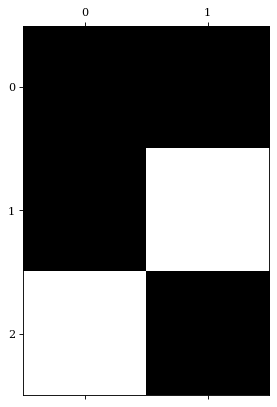

In [211]:
# Here we plot the hierarchical constraints matrix
hplot = HierarchicalPlot(S=S_df, tags=tags)
hplot.plot_summing_matrix()

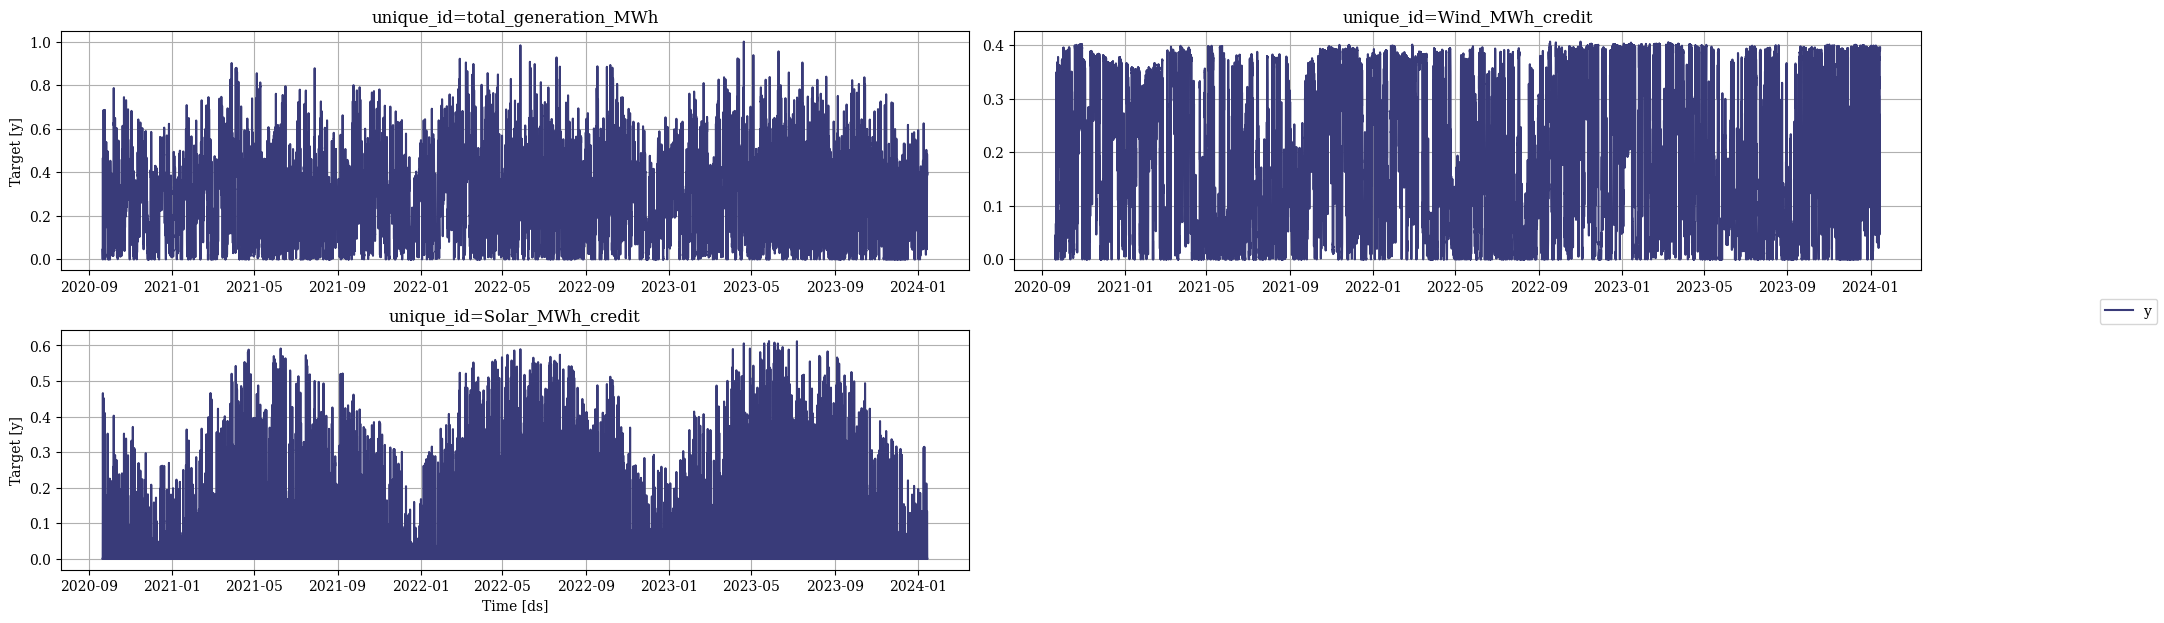

In [284]:
from statsforecast import StatsForecast

StatsForecast.plot(Y_df, engine="matplotlib")

In [298]:
# hplot.plot_hierarchically_linked_series(
#     bottom_series='Solar_MWh_credit',
#     Y_df=Y_df.set_index('unique_id')
# )

In [ ]:
# Here we plot the top most series from the dataset
# that corresponds to the total tourist monthly visits to Australia
plt.figure(figsize=(10, 5))
plt.plot(
    Y_df[Y_df["unique_id"] == "total_generation_MWh"]["ds"],
    Y_df[Y_df["unique_id"] == "total_generation_MWh"]["y"],
    label="target",
)
plt.plot(
    Y_df[Y_df["unique_id"] == "total_generation_MWh"]["ds"],
    Y_df[Y_df["unique_id"] == "total_generation_MWh"]["dayhour"],
    label="dayhour",
)
plt.xlabel("Date")
plt.ylabel("Tourist Visits")
plt.legend()
plt.grid()
plt.show()
plt.close()

## 3. Fit and Predict HINT

The Hierarchical Forecast Network (HINT) combines into an easy to use model three components:<br>
1. SoTA neural forecast model.<br>
2. An efficient and flexible multivariate probability distribution.<br>
3. Builtin reconciliation capabilities.<br>

In [290]:
from neuralforecast import NeuralForecast
from neuralforecast.models import NBEATSx, NHITS, HINT, MLP, TimesNet
from neuralforecast.losses.pytorch import GMM, PMM, DistributionLoss, sCRPS, HuberMQLoss, MQLoss

In [215]:
# Train test splits
horizon = 48
Y_test_df = Y_df.groupby("unique_id").tail(horizon)
Y_train_df = Y_df.drop(Y_test_df.index)
Y_test_df = Y_test_df.set_index("unique_id")
Y_train_df = Y_train_df.set_index("unique_id")

In [250]:
# Horizon and quantiles
level = np.arange(10, 90, 10)
qs = [[50 - lv / 2, 50 + lv / 2] if lv != 0 else [50] for lv in level]
quantiles = np.sort(np.concatenate(qs) / 100)
# level = [80, 90]

# HINT := BaseNetwork + Distribution + Reconciliation
nhits = MLP(
    h=horizon,
    input_size=horizon,
    loss=GMM(n_components=5, quantiles=quantiles),
    # loss=HuberMQLoss(quantiles=quantiles),    # Robust Huber Loss
    # valid_loss=MQLoss(quantiles=quantiles),   # Validation signal
    # hist_exog_list=["month"],
    futr_exog_list=wind_known_dyn_features
    + solar_known_dyn_features
    + other_known_features
    + ["hourminute", "dayhour", "weekday", "monthday", "yearday"],
    max_steps=200,
    early_stop_patience_steps=10,
    val_check_steps=50,
    scaler_type=None,
    learning_rate=1e-4,
    valid_loss=sCRPS(quantiles=quantiles),
    exclude_insample_y=True,
    step_size=horizon,
    windows_batch_size=horizon * 10,
    batch_size=64,
)

model = HINT(h=horizon, S=S_df.values, model=nhits, reconciliation="BottomUp")

INFO:lightning_fabric.utilities.seed:Seed set to 1


In [254]:
import torch

if torch.backends.mps.is_available():
    torch.device("mps")

True

In [ ]:
nf = NeuralForecast(models=[model], freq="30min")
# Y_hat_df = nf.cross_validation(df=Y_df, val_size=12, n_windows=1)
nf.fit(df=Y_train_df, val_size=horizon * 10)
Y_hat_df = nf.predict(futr_df=Y_test_df.reset_index())

In [ ]:
nf.save(path="./checkpoints/test_run/", model_index=None, overwrite=True, save_dataset=True)
# nf = NeuralForecast.load(path="./checkpoints/test_run/")

In [288]:
# StatsForecast.plot(Y_df, Y_hat_df, engine='matplotlib', max_insample_length=48 * 3, level=[70, 80])

In [ ]:
unique_id = target
Y_plot_df = Y_df[Y_df.unique_id == unique_id].tail(horizon * 5)
# Y_hat_df = Y_hat_df.reset_index()
plot_df = Y_hat_df[Y_hat_df.unique_id == unique_id]
plot_df = Y_plot_df.merge(plot_df, on=["unique_id", "ds"], how="left")

plt.plot(plot_df["ds"], plot_df["y"], c="black", label="True")
# plt.plot(plot_df['ds'], plot_df['HINT-median'], c='blue', label='median')
plt.fill_between(
    x=plot_df["ds"][-horizon:],
    y1=plot_df["HINT-lo-40.0"][-horizon:].values,
    y2=plot_df["HINT-hi-40.0"][-horizon:].values,
    alpha=0.4,
    label="level 80",
)
plt.legend()
plt.grid()
plt.plot()

In [ ]:
unique_id = "Wind_MWh_credit"
Y_plot_df = Y_df[Y_df.unique_id == unique_id].tail(horizon * 5)
# Y_hat_df = Y_hat_df.reset_index()
plot_df = Y_hat_df[Y_hat_df.unique_id == unique_id]
plot_df = Y_plot_df.merge(plot_df, on=["unique_id", "ds"], how="left")

plt.plot(plot_df["ds"], plot_df["y"], c="black", label="True")
# plt.plot(plot_df['ds'], plot_df['HINT-median'], c='blue', label='median')
plt.fill_between(
    x=plot_df["ds"][-horizon:],
    y1=plot_df["HINT-lo-40.0"][-horizon:].values,
    y2=plot_df["HINT-hi-40.0"][-horizon:].values,
    alpha=0.4,
    label="level 80",
)
plt.legend()
plt.grid()
plt.plot()

## 4. Forecast Evaluation

To evaluate the coherent probabilistic predictions we use the scaled Continuous Ranked Probability Score (sCRPS), defined as follows:

$$
\mathrm{CRPS}(\hat{F}_{[a,b],\tau},\mathbf{y}_{[a,b],\tau}) =
    \frac{2}{N_{a}+N_{b}} \sum_{i} \int^{1}_{0} \mathrm{QL}(\hat{F}_{i,\tau}, y_{i,\tau})_{q} dq
$$

$$
\mathrm{sCRPS}(\hat{F}_{[a,b\,],\tau},\mathbf{y}_{[a,b\,],\tau}) =
    \frac{\mathrm{CRPS}(\hat{F}_{[a,b\,],\tau},\mathbf{y}_{[a,b\,],\tau})}{\sum_{i} | y_{i,\tau} |}
$$

As you can see the HINT model efficiently achieves state of the art accuracy under minimal tuning.

In [265]:
from hierarchicalforecast.evaluation import scaled_crps


def _get_hierarchical_scrps(hier_idxs, Y, Yq_hat, quantiles):
    # We use the indexes obtained from the aggregation tags
    # to compute scaled CRPS across the hierarchy levels
    scrps_list = []
    for idxs in hier_idxs:
        y = Y[idxs, :]
        yq_hat = Yq_hat[idxs, :, :]
        scrps = scaled_crps(y, yq_hat, quantiles)
        scrps_list.append(scrps)
    return scrps_list


hier_idxs = [np.arange(len(S_df))] + [S_df.index.get_indexer(tags[level]) for level in list(tags.keys())]

In [272]:
%%capture
n_series = len(S_df)
n_quantiles = len(quantiles)

# Bootstrap predictions
n_samples = 1
Y_hat_df_list = [nf.predict(futr_df=Y_test_df.reset_index()) for _ in range(n_samples)]

# Parse y_test and y_rec
# Keep only quantile columns from Y_hat_df
# Removing mean and median default outputs
model_name = type(model).__name__
quantile_columns = [model_name + n for n in nhits.loss.output_names]
quantile_columns.remove(model_name)
Yq_hat = []
for sample_idx in range(n_samples):
    Y_hat = Y_hat_df_list[sample_idx][quantile_columns].values
    Yq_hat.append(Y_hat.reshape(1, n_series, horizon, n_quantiles))

Yq_hat = np.concatenate(Yq_hat, axis=0)
Y_test = Y_test_df["y"].values.reshape(n_series, horizon)

In [279]:
print("Y_test.shape [n_series, horizon]", Y_test.shape)
print("Yq_hat.shape [n_samples, n_series, horizon, n_quantiles]", Yq_hat.shape)

# Compute bootstraped sCRPS
scrps_hint = [
    _get_hierarchical_scrps(hier_idxs, Y_test, Yq_hat[sample_idx], quantiles) for sample_idx in range(n_samples)
]
crps_mean = np.mean(np.array(scrps_hint), axis=0)
crps_std = np.std(np.array(scrps_hint), axis=0)
scrps_hint = [f"{crps_mean[level_idx]:.4f}±{(1.96 * crps_std[level_idx]):.4f}" for level_idx in range(len(crps_mean))]

levels = [
    target,
    "Wind_MWh_credit",
    "Solar_MWh_credit",
]
pd.DataFrame(
    dict(
        Levels=levels,
        HINT=scrps_hint,
    )
)

Y_test.shape [n_series, horizon] (3, 48)
Yq_hat.shape [n_samples, n_series, horizon, n_quantiles] (1, 3, 48, 16)


,Levels,HINT
0,total_generation_MWh,0.5762±0.0000
1,Wind_MWh_credit,0.4286±0.0000
2,Solar_MWh_credit,0.7237±0.0000


## References

- [Kin G. Olivares, David Luo, Cristian Challu, Stefania La Vattiata, Max Mergenthaler, Artur Dubrawski (2023). "HINT: Hierarchical Mixture Networks For Coherent Probabilistic Forecasting". International Conference on Machine Learning (ICML). Workshop on Structured Probabilistic Inference & Generative Modeling. Available at https://arxiv.org/abs/2305.07089.](https://arxiv.org/abs/2305.07089)<br />
- [Kin G. Olivares, O. Nganba Meetei, Ruijun Ma, Rohan Reddy, Mengfei Cao, Lee Dicker (2023)."Probabilistic Hierarchical Forecasting with Deep Poisson Mixtures". International Journal Forecasting, accepted paper. URL https://arxiv.org/pdf/2110.13179.pdf.](https://arxiv.org/pdf/2110.13179.pdf)<br />
- [Kin G. Olivares, Federico Garza, David Luo, Cristian Challu, Max Mergenthaler, Souhaib Ben Taieb, Shanika Wickramasuriya, and Artur Dubrawski (2023). "HierarchicalForecast: A reference framework for hierarchical forecasting". Journal of Machine Learning Research, submitted. URL https://arxiv.org/abs/2207.03517](https://arxiv.org/abs/2207.03517)